# Sentiment Analysis

---

Business Problem: You are working at Foods Inc as a data analyst. The company is a chain of sophisticated restaurants in Brazil and is expanding rapidly, also operating in the Uruguay and Paraguay segments.
The company is currently in the process of modernizing technologies and processes, the company's main focus now is to target customers and products, one of the company's biggest updates is the creation of an online application that works like an "online restaurant", the customer Create an account on the app and order food, after that the restaurant creates food and sends it to the customer's home.
A very simple e-commerce, but for food.
By creating an account, customers can order any type of food available from restaurants near their location. After that, the restaurant creates the order and delivery the food to the customer location, the customer can provide post delivery feedback and a star rating.
This application has been running for a year and the company has collected some raw data and now its challenge is to provide insights with this data set.
One of the main objectives is to create an estimator that works as a validator of sentiment scores.
If the score is 5 and the text is "very bad", you will need to confirm this score with an estimator.

In this small project I aim to train my skills with Spark on multiclass classification problems.

The project basically consists of sentiment analysis pipeline using kaggle dataset product reviews on this link: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews.

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

Dataset Overview:

- *Id*: Row Number.
- *ProductId*: Product that customer buy at a restaurant.
- *UserId*: Customer indentification.
- *ProfileName*: Customer Profile.
- *Time*: Feedback timestamp.
- *HelpfulnessNumerator|HelpfulnessDenominator*: Indicators.
- *Score*: Sentiment.
- *Summary*: A summary of text.
- *Text*: Customer feedback.

## 0.0. Requirements

### 0.1. Imports

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns 
from matplotlib import pyplot as plt

from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql import functions as pf

from pyspark.sql.types import FloatType
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.utils import AnalysisException

### 0.2. Aux Functions

In [2]:
spark = SparkSession.builder \
        .master("local[*]") \
        .config("spark.driver.memory", "7g") \
        .config("spark.executor.memory", "7g") \
        .getOrCreate()

sc = spark.sparkContext

sc

24/06/06 07:45:58 WARN Utils: Your hostname, grc resolves to a loopback address: 127.0.1.1; using 192.168.3.7 instead (on interface eno1)
24/06/06 07:45:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/06 07:45:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
def descriptive_statistics_groupby_score(
    df: DataFrame,
    groupby_col: str = "UserId"
) -> DataFrame:
    return df.groupBy(groupby_col).agg(
            pf.min(pf.col("Score")).alias("min_score"),
            pf.max(pf.col("Score")).alias("max_score"),
            pf.median(pf.col("Score")).alias("median_score"),
            pf.avg(pf.col("Score")).alias("avg_score"),
            pf.stddev(pf.col("Score")).alias("stddev_score"),
            pf.count(pf.col("Score")).alias("quantity_reviews")
        ).orderBy("quantity_reviews", ascending=False)

def plot_daily_scores_time_series(df_time_series: pd.DataFrame):
    fig, ax = plt.subplots(3, 1, figsize=(10, 15))
    ax = ax.flatten()

    df_time_series.groupby("TimeDate").count().plot(grid=2, title="Daily Reviews", ax=ax[0]);

    for score, color in zip([0, 1, 2], ["r", "orange", "green"]):
        df_time_series[df_time_series["Score"] == score].groupby("TimeDate").count().plot(ax=ax[1], grid=2, color=color)
        df_time_series[df_time_series["Score"] == score].groupby("TimeDate").count().diff().dropna().plot(ax=ax[2], color=color, grid=2, linestyle="--")

    ax[1].set_title("Daily Reviews by Scores")
    ax[2].set_title("Daily Differences Scores");

    plt.tight_layout()

def plot_monthly_scores_time_series(df_time_series: pd.DataFrame):
    fig, ax = plt.subplots(3, 1, figsize=(10, 15))
    ax = ax.flatten()

    df_time_series.groupby("TimeDate").count().resample("MS").sum().plot(grid=2, title="Monthly Reviews", ax=ax[0]);

    for score, color in zip([0, 1, 2], ["r", "orange", "green"]):
        df_time_series[df_time_series["Score"] == score].groupby("TimeDate").count().resample("MS").sum().plot(ax=ax[1], grid=2, color=color)
        df_time_series[df_time_series["Score"] == score].groupby("TimeDate").count().resample("MS").sum().diff().dropna().plot(ax=ax[2], color=color, grid=2, linestyle="--")

    ax[1].set_title("Monthly Reviews by Scores")
    ax[2].set_title("Monthly Differences Scores");

    plt.tight_layout()

### 0.3. Read Data

In [11]:
base_path = "../data/"

df_raw = spark.read.format("csv") \
              .option("header", "true") \
              .option("inferSchema", "true") \
              .option("delimiter", ",") \
              .load(base_path + "Reviews.csv")

In [12]:
print(f"Number of Rows: {df_raw.count()}")

df_raw.show(5, truncate=False)

Number of Rows: 568454
+---+----------+--------------+-----------------------------------+--------------------+----------------------+-----+----------+-------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id |ProductId |UserId        |ProfileName                        |HelpfulnessNumerator|HelpfulnessDenominator|Score|Time      |Summary                  |Text                                                                                                                                                                                                                                                                                     

### 0.4. Split Dataset

#### 0.4.1. Noisy Checkout

In this step, I will split into training and testing datasets and a function to fix the scores into three main categories (bad, neural, and good).

But there are some noisy data in both profile scores and names, such as noisy scores and strange names.

In [13]:
df_raw.filter(~pf.col("Score").isin([0, 1, 2, 3, 4, 5])).show(5)

print(f"Total noisy Scores data: {df_raw.filter(~pf.col('Score').isin([0, 1, 2, 3, 4, 5])).count()}")

+----+----------+--------------+--------------------+--------------------+----------------------+--------------+----+----------+--------------------+
|  Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|         Score|Time|   Summary|                Text|
+----+----------+--------------+--------------------+--------------------+----------------------+--------------+----+----------+--------------------+
| 523|B000G6RYNE|A3MFU0GVZUVH3K|"Betty L. Dravis ...|  author/reviewer"""|                    43|            47|   5|1207094400|Love at first bit...|
|3018|B0025UALB6| AJD41FBJD9010|  "N. Ferguson ""Two|               Daisy|                Hannah| and Kitten"""|   0|         0|                   5|
|3415|B005K4Q1VI|A3U41ZL33SS92P|"Kevin Nicholls "...|    aging hipster"""|                     6|             6|   2|1322438400|At least it wasn'...|
|4105|B001EW5YQS|A32ENLNRSM1NZG|"Larry Wagner ""A...|             Analyst|                 Coach|   

In [14]:
# Display Current Scores
print("Current Scores")
df_raw.groupBy(pf.col("Score")).count().orderBy("count", ascending=False).show(10)

# Filter Rows
df_raw = df_raw.filter(pf.col("Score").isin([0, 1, 2, 3, 4, 5]))

# Create New Scores
df_raw = df_raw.withColumn(
    "Score",
    pf.when(pf.col("Score") < 2, 0) \
      .when((pf.col("Score") >= 2) & (pf.col("Score") < 4), 1) \
      .when(pf.col("Score") >= 4, 2)
)

print("New Scores")
df_raw.groupBy("Score").count().orderBy("count", ascending=False).show()

Current Scores
+---------------+------+
|          Score| count|
+---------------+------+
|              5|361648|
|              4| 80141|
|              1| 52635|
|              3| 42502|
|              2| 29877|
|              0|  1111|
|  and Kitten"""|   104|
|book-blogger"""|    59|
|              7|    41|
|              6|    38|
+---------------+------+
only showing top 10 rows

New Scores
+-----+------+
|Score| count|
+-----+------+
|    2|441789|
|    1| 72379|
|    0| 53746|
+-----+------+



For train test split I will consider three datasets.

- OOT: Out of Time (Time shift dataset for sentiment in future).
- Train Dataset: Dataset for train Estimators and Exploratory.
- Test Dataset: Dataset for train estimators.

In real life, the customer behavior of sentiment changes, is possible to capture a product quality over time and customer sentiment over time, in a production scenario the OOT is very important because is a shift behavior of the estimation purposes.

In [15]:
df_raw = df_raw.withColumn(
    "Time",
    pf.to_timestamp(pf.from_unixtime("Time"))
)

Ok, is very strange, exists reviews below 20's.

I will consider reviews only greather or equal to 2003. This dataset is from Amazon, Amazon is created at 1994, but i will give a greather time gap for filter this reviews, is possible to check this reviews with data engineering team of amazon if this make sense, can be a error in time input of ETL process or a bug in moment of the customer create a review in amazon app or website.

In My business Problem i assume the Foods Inc is created in 19's too, but start working and having high relevance after 2003.

In [16]:
df_raw.select(pf.min("Time"), pf.max("Time")).show()

df_raw.select(pf.year("Time").alias("time_year")).groupBy("time_year").count().orderBy("time_year", ascending=False).show()

df_raw.filter(pf.year("Time") == 1969).show()

# Filter Years
df_raw = df_raw.filter(pf.year("Time") >= 2003)

+-------------------+-------------------+
|          min(Time)|          max(Time)|
+-------------------+-------------------+
|1969-12-31 21:00:00|2012-10-25 22:00:00|
+-------------------+-------------------+

+---------+------+
|time_year| count|
+---------+------+
|     2012|197232|
|     2011|162878|
|     2010| 85696|
|     2009| 54964|
|     2008| 33947|
|     2007| 22223|
|     2006|  6618|
|     2005|  1331|
|     2004|   558|
|     2003|   132|
|     2002|    73|
|     2001|    13|
|     2000|    32|
|     1999|     6|
|     1969|  2211|
+---------+------+

+----+----------+--------------+--------------------+--------------------+----------------------+-----+-------------------+----------+--------------------+
|  Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|               Time|   Summary|                Text|
+----+----------+--------------+--------------------+--------------------+----------------------+-----+------------

#### 0.4.2. Split Dataset

For OOT split the dataset I selected to consider 2021 and month greather than 06. For train and test is a proportion random split with a seed for reproducibility.

In modelling notebook is a good test to undersampling the majority class to minority class for machine learning.

In [18]:
df_raw.filter(pf.year("Time") == 2012)\
    .select((pf.concat_ws("-", pf.year("Time").cast("string"), pf.month("Time").cast("string"))).alias("year_month")) \
    .groupBy("year_month").count().orderBy("year_month", ascending=True).show()

+----------+-----+
|year_month|count|
+----------+-----+
|    2012-1|21659|
|   2012-10|19634|
|    2012-2|18746|
|    2012-3|19479|
|    2012-4|19014|
|    2012-5|19379|
|    2012-6|17789|
|    2012-7|19948|
|    2012-8|19679|
|    2012-9|21905|
+----------+-----+



In [19]:
# Create OOT 
df_oot = df_raw.filter(
    (pf.year("Time") == 2012) &
    (pf.month("Time") >= 6)
)

# Remove OOT from Original Dataframe
df_base = df_raw.join(
    df_oot.select("Id", pf.col("Id").alias("IdOot")),
    how="left",
    on="Id"
).filter(pf.col("IdOot").isNull())

df_base = df_base.drop("idOot")

# Random Split into Train and Test
df_train, df_test = df_base.randomSplit(weights=[.8, .2], seed=42)

In [20]:
for df, tag in zip([df_oot, df_test, df_train], ["oot", "test", "train"]):
    print(f"{tag} Dataset Size: {df.count()}")
    df.groupBy("Score").count().orderBy("Score").show()

del df, tag

oot Dataset Size: 98955


+-----+-----+
|Score|count|
+-----+-----+
|    0|10024|
|    1|13036|
|    2|75895|
+-----+-----+



test Dataset Size: 92879


+-----+-----+
|Score|count|
+-----+-----+
|    0| 8470|
|    1|11562|
|    2|72847|
+-----+-----+



train Dataset Size: 373745


+-----+------+
|Score| count|
+-----+------+
|    0| 33625|
|    1| 47355|
|    2|292765|
+-----+------+



In [21]:
# Save intermediate dataframe in disk to stop working with a giant CSV 
#df_oot.coalesce(1).write.format("parquet").save("../data/oot")
df_train.coalesce(1).write.format("parquet").save("../data/train")
#df_test.coalesce(1).write.format("parquet").save("../data/test")

## 1.0. Descriptive Statistics

In [4]:
df = spark.read.format("parquet").load("../data/train")

### 1.1. Data Dimension

In [5]:
print(f"Number of Rows: {df.count()}")
print(f"Number of Columns: {len(df.columns)}")

Number of Rows: 373745
Number of Columns: 10


In [6]:
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



### 1.2. Check Missing Values

In [7]:
df.select([pf.count(pf.when(pf.isnull(pf.col(k)), 1)).alias(k) for k in df.columns]).show()

+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
| Id|ProductId|UserId|ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|Time|Summary|Text|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
|  0|        0|     0|          0|                   0|                     0|    0|   0|      0|   0|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+



### 1.3. Descriptive Statistics

Exists a total of 57289 unique products and 181633 unique customers, with 158747 unique profile names, exists customers with the same profile name but with different UserId.

#### 1.3.1. Numeric Features

In [8]:
df_numeric = df.select([k.name for k in df.schema if k.dataType.typeName() in ["double", "integer"]])

df_numeric.describe().show()

+-------+------------------+------------------+
|summary|                Id|             Score|
+-------+------------------+------------------+
|  count|            373745|            373745|
|   mean|283379.53542923654|1.6933604462935958|
| stddev|163853.12523054992|0.6265367552280299|
|    min|                 1|                 0|
|    max|            568454|                 2|
+-------+------------------+------------------+



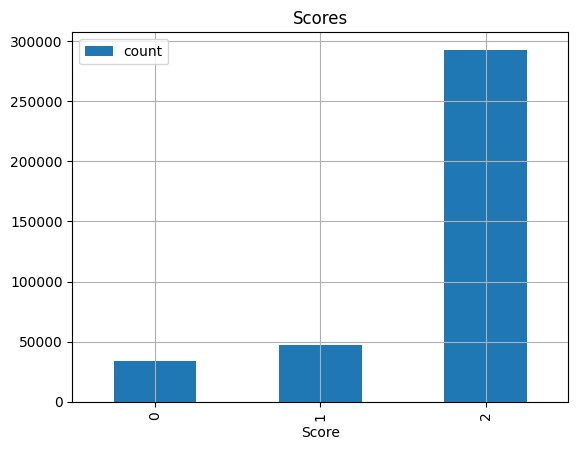

In [9]:
dfs = df_numeric.select("Score").groupby("Score").count().toPandas()
dfs.set_index("Score").sort_values(by="count").plot(kind="bar", grid=2, title="Scores");

In [10]:
del dfs, df_numeric

#### 1.3.2. Categorical Features

In [11]:
df_categorical = df.select(["ProductId", "UserId", "ProfileName"])
df_categorical_distinct = df.select([pf.count_distinct(pf.col(k)).alias(k) for k in df_categorical.columns])
df_categorical_distinct = df_categorical_distinct.withColumn("summary", pf.lit("count_distinct"))

In [12]:
df_categorical.describe().union(df_categorical_distinct.select(["summary"] + df_categorical_distinct.columns[:-1])).show()

+--------------+--------------------+------------------+--------------+
|       summary|           ProductId|            UserId|   ProfileName|
+--------------+--------------------+------------------+--------------+
|         count|              373745|            373745|        373745|
|          mean| 6.719059623150628E9|              null|           NaN|
|        stddev|2.0033411892075891E9|              null|           NaN|
|           min|          0006641040|#oc-R10LT57ZGIB140|            |
|           max|          B009UUS05I|     AZZZOVIBXHGDR|Étaín d'Orphée|
|count_distinct|               57289|            181633|        158747|
+--------------+--------------------+------------------+--------------+



In [13]:
del df_categorical, df_categorical_distinct

#### 1.3.3. Checking Descriptive Statistics

##### 1.3.3.1. Duplicated Profiles

Same customer can have the same profile name but different id.

The customer with profile name "Stephanie" have 164 reviews, but exists multiple customers with same profile name of "Stephanie" and different user id.    

In [14]:
df.select("ProfileName").groupBy("profileName").count().orderBy("count", ascending=False).show(truncate=False)

+------------------------------------------+-----+
|profileName                               |count|
+------------------------------------------+-----+
|"O. Brown ""Ms. O. Khannah-Brown"""       |338  |
|"C. F. Hill ""CFH"""                      |314  |
|"Rebecca of Amazon ""The Rebecca Review"""|274  |
|Gary Peterson                             |225  |
|Chris                                     |218  |
|c2                                        |180  |
|Linda                                     |180  |
|Laura                                     |177  |
|Gunner                                    |168  |
|Lisa                                      |164  |
|christopher hayes                         |164  |
|Stephanie                                 |164  |
|John                                      |159  |
|Jen                                       |154  |
|Mike                                      |153  |
|Karen                                     |150  |
|Jared Castle                  

In [15]:
df.select("ProfileName", "UserId").groupBy("UserId", "profileName").count().orderBy("count", ascending=False).show(truncate=False)

+--------------+----------------------------------------------+-----+
|UserId        |profileName                                   |count|
+--------------+----------------------------------------------+-----+
|A1YUL9PCJR3JTY|"O. Brown ""Ms. O. Khannah-Brown"""           |338  |
|A3OXHLG6DIBRW8|"C. F. Hill ""CFH"""                          |314  |
|A281NPSIMI1C2R|"Rebecca of Amazon ""The Rebecca Review"""    |274  |
|AY12DBB0U420B |Gary Peterson                                 |225  |
|A1Z54EM24Y40LL|c2                                            |180  |
|A1TMAVN4CEM8U8|Gunner                                        |165  |
|A3TVZM3ZIXG8YW|christopher hayes                             |164  |
|A3PJZ8TU8FDQ1K|Jared Castle                                  |143  |
|A2MUGFV2TDQ47K|"Lynrie ""Oh HELL no"""                       |141  |
|A31N6KB160O508|Fran W.                                       |139  |
|A29JUMRL1US6YP|HTBK                                          |137  |
|A2SZLNSI5KOQJT|"Car

In [16]:
df.filter(pf.lower(pf.col("ProfileName")).like("%stephanie%")).select("UserId", "ProfileName").distinct().show(truncate=False)

+--------------+------------------------------------------------+
|UserId        |ProfileName                                     |
+--------------+------------------------------------------------+
|A1CI0PIU3RU554|Stephanie Dragon                                |
|A3OOUE13RP4859|"Stephanie Saia ""curlgirl"""                   |
|A3DHPK4XCCNF5Q|Stephanie Borgatti                              |
|AA40TUXF44XM6 |stephanie ely                                   |
|ASWTTNI9QMAVT |stephanie                                       |
|A33ARC96U5FW9X|Stephanie A. Rowe                               |
|A240QYGHE1OT9Z|Stephanie                                       |
|AZ92P5RFULPIA |Stephanie                                       |
|A3NLFAALMQFUJ7|Stephanie Snow                                  |
|A114836YYULL5V|Stephanie R. Manley                             |
|A1NLQCU416R4CI|"Stephanie Brooks ""Cool Mom"""                 |
|A2YVPRYDKOXI82|"Stephanie Schultz ""UsfSteph"""                |
|A2LKMVH5N

##### 1.3.3.2. Score Users

There is an influential detractor, he/she has 164 reviews and all of them are negative (with a score of zero).

But looking at reviews, is very strange, all 164 is equal for different products.

The second with only negative scores looks like the same pattern.

With a very simple proportion i check that 0.002 or 0.2 % of reviews is duplicated based on UserId, ProductId, Text and Score.

In [17]:
df_user_metrics = descriptive_statistics_groupby_score(df, "UserId")

df_user_metrics.show()

+--------------+---------+---------+------------+------------------+-------------------+----------------+
|        UserId|min_score|max_score|median_score|         avg_score|       stddev_score|quantity_reviews|
+--------------+---------+---------+------------+------------------+-------------------+----------------+
|A1YUL9PCJR3JTY|        1|        2|         2.0|1.9319526627218935|0.25220047159199993|             338|
|A3OXHLG6DIBRW8|        1|        2|         2.0|1.9394904458598725|0.23880906907804392|             314|
|A281NPSIMI1C2R|        1|        2|         2.0| 1.948905109489051|0.22059419866945276|             274|
| AY12DBB0U420B|        1|        2|         2.0|1.9333333333333333|0.25000000000000006|             225|
|A1Z54EM24Y40LL|        0|        2|         2.0|1.8111111111111111|0.44582343486113896|             180|
|A1TMAVN4CEM8U8|        1|        2|         2.0|1.9454545454545455| 0.2277821342098376|             165|
|A3TVZM3ZIXG8YW|        0|        0|         0

In [18]:
df_user_metrics.filter((pf.col("quantity_reviews") >= 10) & (pf.col("max_score") == 0)).show()

df.filter(pf.col("UserId") == "A3TVZM3ZIXG8YW").show(10, truncate=False)
df.filter(pf.col("UserId") == "A3TVZM3ZIXG8YW").select("ProductId", "UserId", "Score", "Text").distinct().show(10, truncate=False)
df.filter(pf.col("UserId") == "A3TVZM3ZIXG8YW").select("UserId", "Text").distinct().show(10, truncate=False)
df.filter(pf.col("UserId") == "A3IE3TQ79W0YOR").distinct().show(10, truncate=False)

+--------------+---------+---------+------------+---------+------------+----------------+
|        UserId|min_score|max_score|median_score|avg_score|stddev_score|quantity_reviews|
+--------------+---------+---------+------------+---------+------------+----------------+
|A3TVZM3ZIXG8YW|        0|        0|         0.0|      0.0|         0.0|             164|
|A3IE3TQ79W0YOR|        0|        0|         0.0|      0.0|         0.0|              30|
|A1AAOIZQ5JNUVL|        0|        0|         0.0|      0.0|         0.0|              24|
|A10PJEHY3JKKQG|        0|        0|         0.0|      0.0|         0.0|              24|
|A26KCYEWGTQEBV|        0|        0|         0.0|      0.0|         0.0|              23|
|A1P6S7F4MD476C|        0|        0|         0.0|      0.0|         0.0|              22|
|A2WNN1DQVL4LH5|        0|        0|         0.0|      0.0|         0.0|              22|
| ADPCK648WY0LZ|        0|        0|         0.0|      0.0|         0.0|              21|
|A1HNIYASP

In [19]:
df_user_metrics.filter((pf.col("quantity_reviews") >= 10) & (pf.col("max_score") == 2) & (pf.col("min_score") == 2)).show()

+--------------+---------+---------+------------+---------+------------+----------------+
|        UserId|min_score|max_score|median_score|avg_score|stddev_score|quantity_reviews|
+--------------+---------+---------+------------+---------+------------+----------------+
|A1LZJZIHUPLDV4|        2|        2|         2.0|      2.0|         0.0|             121|
| AYB4ELCS5AM8P|        2|        2|         2.0|      2.0|         0.0|              76|
|A3OXRFCJI67IMN|        2|        2|         2.0|      2.0|         0.0|              71|
|A1XGFW5016CGQI|        2|        2|         2.0|      2.0|         0.0|              58|
|A20P8VC55KPPCT|        2|        2|         2.0|      2.0|         0.0|              54|
|A1GQAKL9CGQLP1|        2|        2|         2.0|      2.0|         0.0|              49|
|A3UUTDX2WNVUS3|        2|        2|         2.0|      2.0|         0.0|              47|
|A2T5VEAFT6PUH3|        2|        2|         2.0|      2.0|         0.0|              46|
|A1G60ANYI

In [20]:
df.filter(pf.col("UserId") == "A1LZJZIHUPLDV4").distinct().show(10, truncate=False)
df.filter(pf.col("UserId") == "AYB4ELCS5AM8P").distinct().show(10, truncate=False)
df.filter(pf.col("UserId") == "A3OXRFCJI67IMN").distinct().show(10, truncate=False)
df.filter(pf.col("UserId") == "A1XGFW5016CGQI").distinct().show(10, truncate=False)

+------+----------+--------------+-------------------------------------+--------------------+----------------------+-----+-------------------+---------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
1 - (df.select("UserId", "ProductId", "Score", "Text").distinct().count() / df.count())

0.0025445156456942453

In [22]:
del df_user_metrics

##### 1.3.3.3. Score Products

The reviews of the worst evaluated products are very funny to read, apparently in the statistical description of the worst products they are all normal, nothing very discrepant looking only at the worst evaluated products.

The Wrost produt is removed from Amazon, or the Id is changed over time, but the top product is possible to see in amazon today too.

The Top product: https://www.amazon.com/gp/product/B001EO5U3I

In [23]:
df_product_metrics = descriptive_statistics_groupby_score(df, "ProductId")

df_product_metrics.show()

+----------+---------+---------+------------+------------------+-------------------+----------------+
| ProductId|min_score|max_score|median_score|         avg_score|       stddev_score|quantity_reviews|
+----------+---------+---------+------------+------------------+-------------------+----------------+
|B0026KNQSA|        0|        2|         2.0|1.7437070938215102| 0.5529221673829936|             437|
|B007M83302|        0|        2|         2.0| 1.744186046511628| 0.5501863746868814|             430|
|B000KV61FC|        0|        2|         2.0|1.3613053613053614| 0.7282639531849509|             429|
|B000KV7ZGQ|        0|        2|         1.0|  1.34037558685446| 0.7350798914661518|             426|
|B0026KPDG8|        0|        2|         2.0|1.7505882352941176| 0.5310241816198569|             425|
|B006HYLW32|        0|        2|         2.0|  1.75177304964539| 0.5484492792215085|             423|
|B000NMJWZO|        0|        2|         2.0|1.9666666666666666|0.2159141819560942

In [24]:
df_product_metrics.filter((pf.col("quantity_reviews") >= 3) & (pf.col("max_score") == 0)).show()

df.filter(pf.col("ProductId") == "B004V6A9SC").show(10, truncate=False)
df.filter(pf.col("ProductId") == "B0012VNB70").show(10, truncate=False)

+----------+---------+---------+------------+---------+------------+----------------+
| ProductId|min_score|max_score|median_score|avg_score|stddev_score|quantity_reviews|
+----------+---------+---------+------------+---------+------------+----------------+
|B004V6A9SC|        0|        0|         0.0|      0.0|         0.0|               7|
|B0012VNB70|        0|        0|         0.0|      0.0|         0.0|               4|
|B001HTRDVM|        0|        0|         0.0|      0.0|         0.0|               4|
|B001KPUHJ8|        0|        0|         0.0|      0.0|         0.0|               4|
|B001VRYRDW|        0|        0|         0.0|      0.0|         0.0|               4|
|B00212EDVW|        0|        0|         0.0|      0.0|         0.0|               4|
|B0026A30PY|        0|        0|         0.0|      0.0|         0.0|               4|
|B003SKY9IS|        0|        0|         0.0|      0.0|         0.0|               4|
|B003WEC9J6|        0|        0|         0.0|      0.0

In [26]:
df_product_metrics.filter((pf.col("quantity_reviews") >= 5) & (pf.col("max_score") == 2) & (pf.col("min_score") == 2)).show()

df.filter(pf.col("ProductId") == "B000ED9L9E").show(10, truncate=False)
df.filter(pf.col("ProductId") == "B004UBZBMW").show(10, truncate=False)
df.filter(pf.col("ProductId") == "B004UC7CMS").show(10, truncate=False)

+----------+---------+---------+------------+---------+------------+----------------+
| ProductId|min_score|max_score|median_score|avg_score|stddev_score|quantity_reviews|
+----------+---------+---------+------------+---------+------------+----------------+
|B000ED9L9E|        2|        2|         2.0|      2.0|         0.0|              66|
|B004UBZBMW|        2|        2|         2.0|      2.0|         0.0|              45|
|B004UC7CMS|        2|        2|         2.0|      2.0|         0.0|              39|
|B000S0XFNQ|        2|        2|         2.0|      2.0|         0.0|              36|
|B0017WFX6G|        2|        2|         2.0|      2.0|         0.0|              34|
|B004JLRYC8|        2|        2|         2.0|      2.0|         0.0|              33|
|B000E671X4|        2|        2|         2.0|      2.0|         0.0|              32|
|B000EDBQ6A|        2|        2|         2.0|      2.0|         0.0|              31|
|B000EGZ99M|        2|        2|         2.0|      2.0

In [25]:
df.filter(pf.col("ProductId") == "B000ED9L9E").show(100, truncate=False)

+------+----------+--------------+---------------------------------------------------+--------------------+----------------------+-----+-------------------+--------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
del df_product_metrics

##### 1.3.3.5. Score Over Time

In [28]:
df_time_series = df.withColumn(
    "TimeDate",
    pf.to_date("Time")
).select("Score", "TimeDate").filter(pf.col("TimeDate") >= "2010-01-01").toPandas()

df_time_series["TimeDate"] = pd.to_datetime(df_time_series["TimeDate"])

Is possible to see a anomaly in December. Maybe is the crazy customer with duplicated reviews. The daily time series do not show any pattern, just a smooth up trend.

Is possible to see another anomaly in negative reviews at december of 2010.

The main ideia with this plot is to check some anomaly or pattern over time.

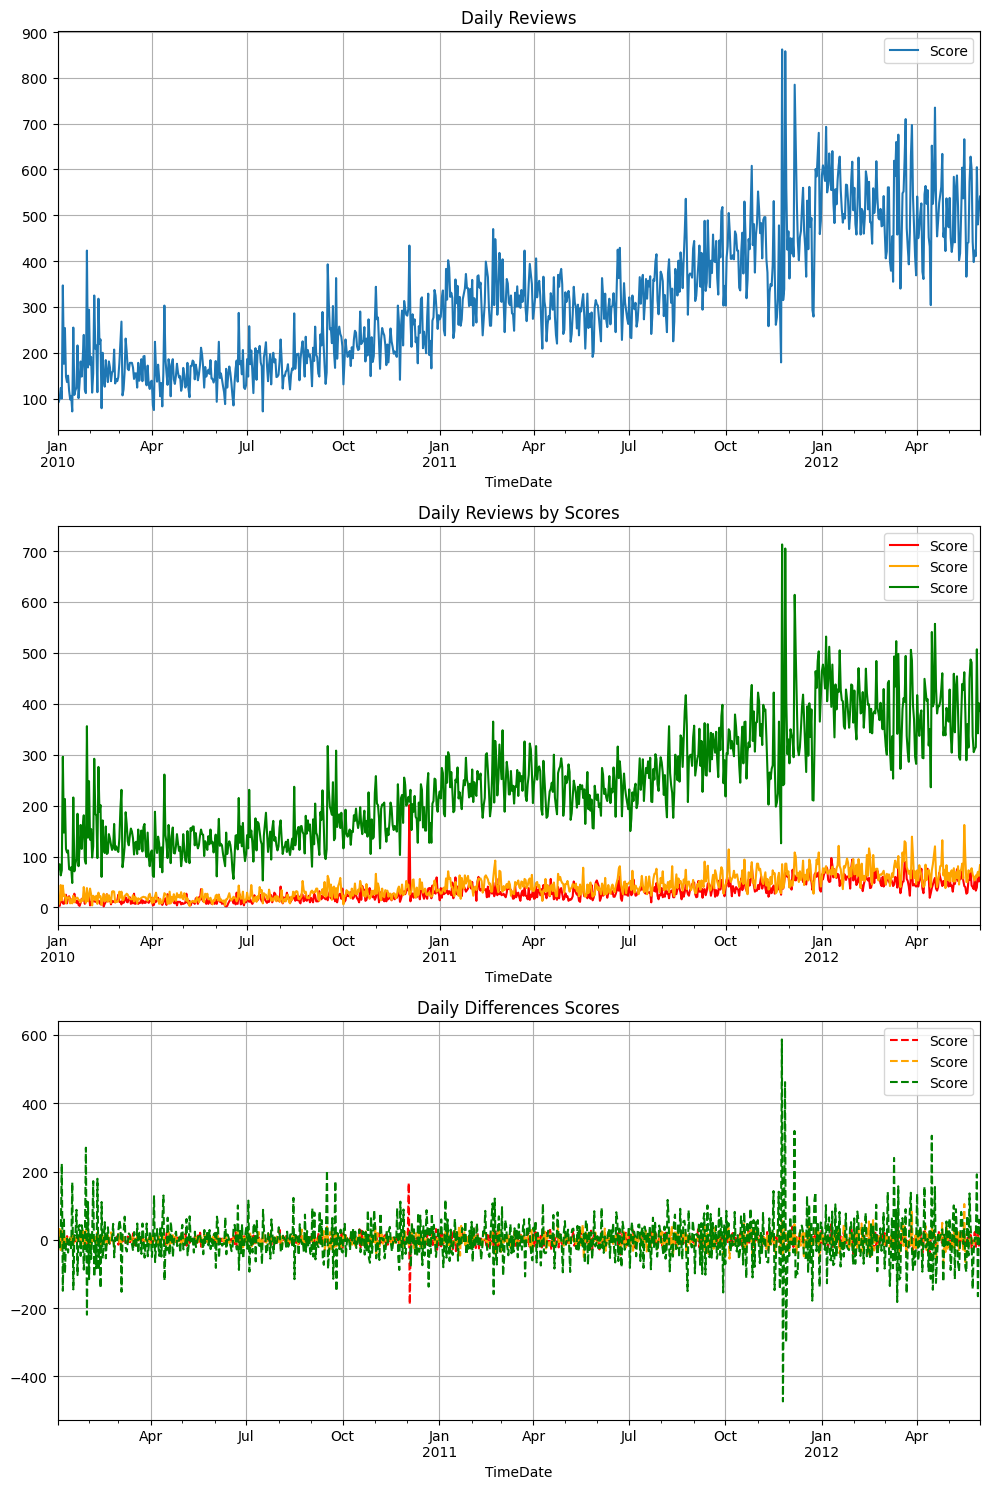

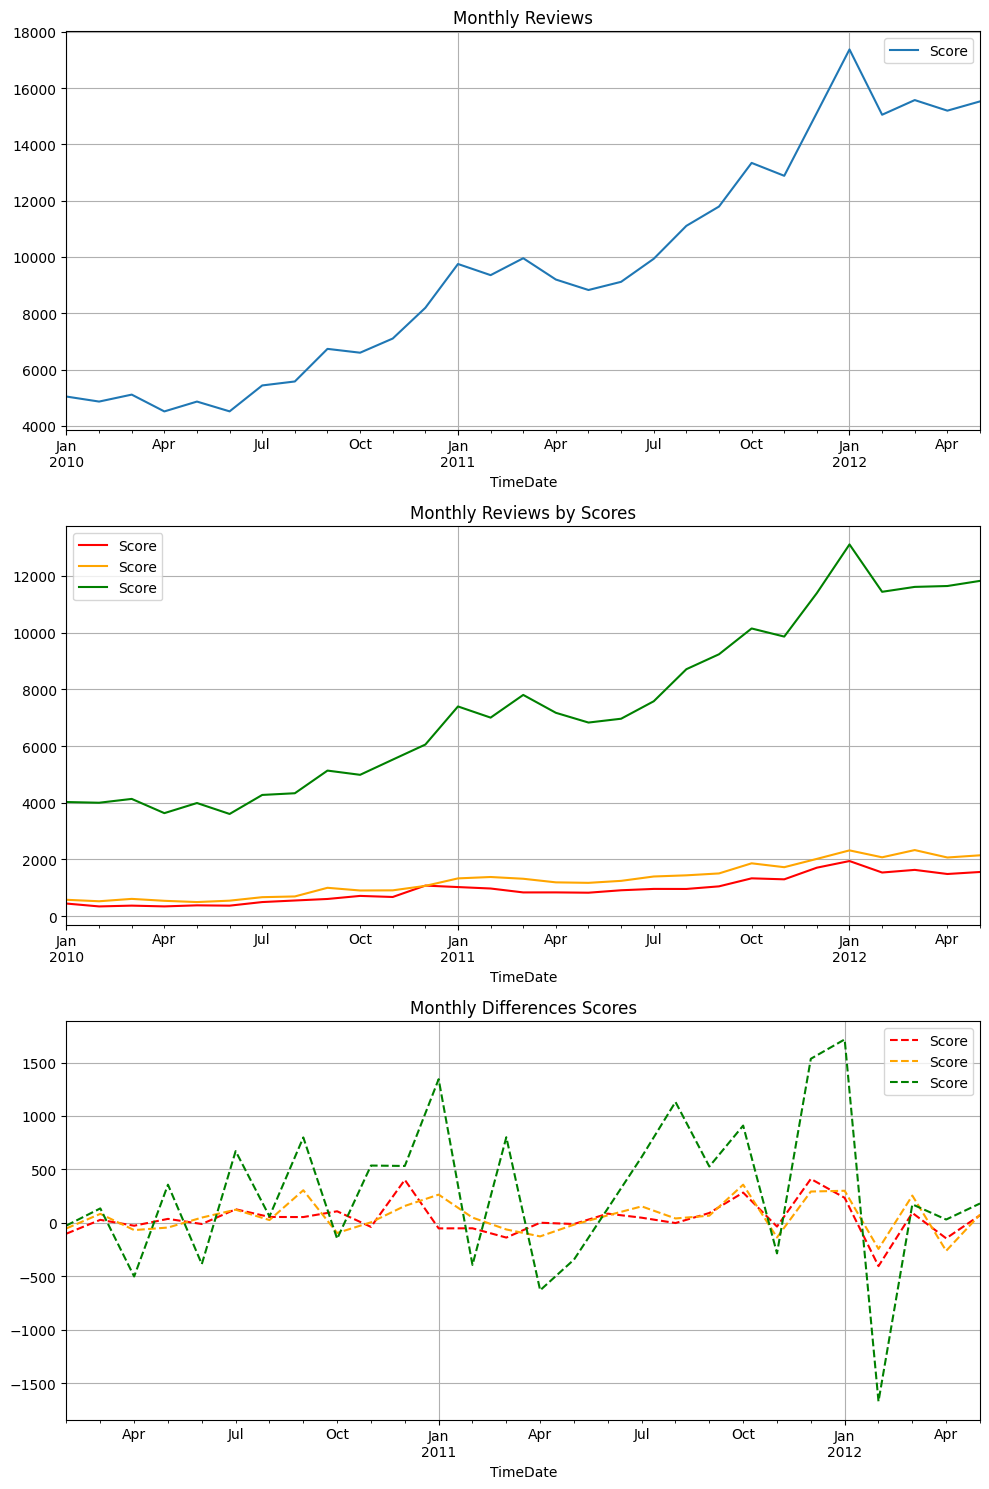

In [29]:
plot_daily_scores_time_series(df_time_series)
plot_monthly_scores_time_series(df_time_series)

In [30]:
del df_time_series

## 2.0. Data Filtering

Now I will remove the duplicate reviews based on all key available columns, or 0.2% of the reviews from the training dataset, and I will eliminate the HelpnessNumerator and HelpnessDenominator because they are irrelevant from my perspective and I don't know who this means and how these resources help me identify the sentiment of the text or insights, in kaggle there is no description about these indicators.

Another feature that i will remove is the Time feature, i always splitted the dataset in OOT, Train and Test, the time feature for machine learning sentiment estimator is irrelevant.

For filtering and keep Id columns, i will assume a append only sistem of reviews and the Id is a autoincrement, if the same reviews come at system two times, the Id is autoincrement and if i get Max(Id) i retrieve the last insert of this respective row.

In [31]:
df = df.select("Id", "ProductId", "UserId", "ProfileName", "Summary", "Text", "Score")
df_filter = df.groupBy(["ProductId", "UserId", "ProfileName", "Summary", "Text", "Score"]).agg(pf.max(pf.col("Id")).alias("Id"))
df_filter = df_filter.select(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text'])

duplicated_rows_pct = 1 - df_filter.count() / df.count()
duplciated_rows_cnt = df.count() - df_filter.count()

print(f"Total Duplicated Rows: {duplciated_rows_cnt}, ({duplicated_rows_pct * 100:.2f}% of Total).")

Total Duplicated Rows: 638, (0.17% of Total).


In [32]:
df_filter.show(2)

+---+----------+--------------+-----------+-----+--------------------+--------------------+
| Id| ProductId|        UserId|ProfileName|Score|             Summary|                Text|
+---+----------+--------------+-----------+-----+--------------------+--------------------+
| 71|B001GVISJC|A27TKQHFW0FB5N|       Chet|    2|        Great Gummi!|These Albanese gu...|
|202|B0028C44Z0|A3VAYCK681VZZO|    Optimus|    2|Love these! And r...|I love, and use t...|
+---+----------+--------------+-----------+-----+--------------------+--------------------+
only showing top 2 rows



## 3.0. Data Preprocessing

In this new topic I will basically work on cleaning the data, that is, removing the HTML codes that are inside the Reviews and padronize the texts all using only SQL or pyspark dataframe syntax, in this moment i do not use NLP classic tools such as tokenizer, lemmatizer or stemming.

I will combine Summary with Text in a simple feature engineering.

### 3.1. Cleaning Text

In [36]:
df = df_filter.select(
    pf.col("Id"),
    pf.col("ProductId"),
    pf.col("UserId"),
    pf.col("Score"),
    pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.trim(pf.lower(pf.col("ProfileName"))), r'\s+', " "), r'<[^>]+>', " "), '"', '').alias("ProfileName"),
    pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.trim(pf.lower(pf.regexp_replace(pf.col("Summary"), '-', ''))), r'[.,]+', '. '), r'<[^>]+>', " "), r'\(.+?\)', ''), '"', ''), r'\s+', " "), ":", "").alias("Summary"),
    pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.trim(pf.lower(pf.regexp_replace(pf.col("Text"), '-', ''))), r'[.,]+', '. '), r'<[^>]+>', " "), r'\(.+?\)', ''), '"', ''), r'\s+', " "), ":", "").alias("Text")
)

### 3.2. Simple Data Engineering

In [37]:
df = df.withColumn("Text", pf.regexp_replace(pf.concat_ws(" ", pf.col("Summary"), pf.col("Text")), r"\s+", " ")).drop("Summary")

In [38]:
df.show(5, truncate=False)

+---+----------+--------------+-----+--------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id |ProductId |UserId        |Score|ProfileName               |Text                                                                                                                                                

In [39]:
# Save intermediate dataset
df.coalesce(1).write.format("parquet").mode("overwrite").save("../data/train")